In [1]:
# résolution de l'EDP de Black-Scholes par différences finies

import time

import matplotlib.pyplot as plt
# librairies
import numpy as np
import scipy
from scipy.stats import norm

In [2]:
# paramètres financiers
S0 = 247.12
r = 0.035
sigma = 0.2
T = 2.
K = 269.99

In [37]:
# paramètres numériques
N = 1000000  # nb de points en prix
M = 1000  # nb de points en temps
Smax = 1000  # prix maximum pour la résolution
dt = T / M
ds = Smax / N
print("Les pas de temps et prix sont:", dt, ds)

Les pas de temps et prix sont: 0.002 0.001


In [38]:
# initialisation de la matrice C (valeurs de l'option)
C = np.zeros((M + 1, N + 1))
# tableau des prix S
S = ds * np.arange(N + 1)
# tableau des temps t
t = dt * np.arange(M + 1)
# prix finaux t=T
C[M, :] = np.maximum(S - K, 0)
# conditions aux bords en prix
C[:, 0] = 0.
C[:, N] = Smax - K * np.exp(-r * (T - t))

In [39]:
# matrice du système linéaire (qui ne dépend pas du temps)
#A = np.zeros((N-1,N-1))
A = scipy.sparse.diags_array((-1 / dt - (sigma ** 2 / ds ** 2) * S[1:N] ** 2 - r * S[1:N] / ds - r,
                              0.5 * (sigma / ds) ** 2 * S[1:N - 1] ** 2 + r / ds * S[1:N - 1],
                              0.5 * (sigma / ds) ** 2 * S[2:N] ** 2),
                             offsets=[0, 1, -1])


In [40]:
# on lance le chronomètre

LU = scipy.sparse.linalg.splu(A)

start = time.time()
# boucle en temps
for i in range(M - 1, -1, -1):
    # vecteur du second membre
    b = -1 / dt * C[i + 1, 1:N]
    # ajout des conditions aux bords
    b[0] += -0.5 * (sigma / ds) ** 2 * S[1] ** 2 * C[i, 0]
    b[N - 2] += (-0.5 * (sigma / ds) ** 2 * S[N - 1] ** 2 - r / ds * S[N - 1]) * C[i, N]
    # résolution du système Ax=b
    C[i, 1:N] = LU.solve(b)
end = time.time()
print(end - start)

/tmp/ipykernel_74708/2187326022.py:3: SparseEfficiencyWarning: splu converted its input to CSC format
  LU = scipy.sparse.linalg.splu(A)


27.768905639648438


In [41]:
# valeur de l'option à l'instant 0 (à la signature) pour différents prix d'actif
C[0, :]

array([0.00000000e+000, 1.58092900e-232, 4.10466989e-229, ...,
       7.48260992e+002, 7.48261993e+002, 7.48262993e+002])

In [42]:
# valeur exacte de la solution
C0exact = S * norm.cdf((np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))) \
          - K * np.exp(-r * T) * norm.cdf((np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))

/tmp/ipykernel_74708/3359761058.py:2: RuntimeWarning: divide by zero encountered in log
  C0exact = S * norm.cdf((np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))) \
/tmp/ipykernel_74708/3359761058.py:3: RuntimeWarning: divide by zero encountered in log
  - K * np.exp(-r * T) * norm.cdf((np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))


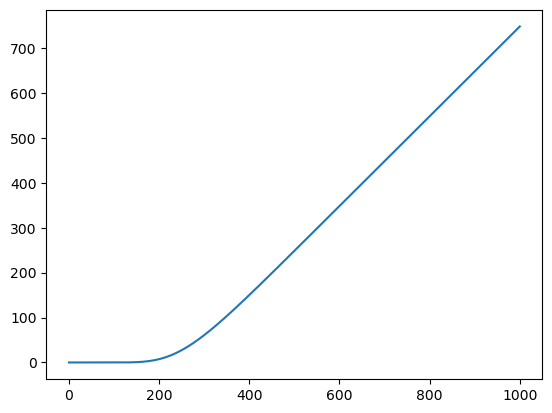

In [43]:
plt.plot(S, C[0, :])

In [11]:
max(abs(C[0, :] - C0exact))

737.7899766749923

In [12]:
C0exact

array([0.00000000e+00, 5.06552644e-86, 2.94434610e-66, ...,
       7.46263008e+02, 7.47263007e+02, 7.48263007e+02])

In [13]:
# changement de schéma => explicite en temps

# initialisation de la matrice C2 (valeurs de l'option)
C2 = np.zeros((M + 1, N + 1))
# tableau des prix S
S = ds * np.arange(N + 1)
# tableau des temps t
t = dt * np.arange(M + 1)
# prix finaux t=T
C2[M, :] = np.maximum(S - K, 0)
# conditions aux bords en prix
C2[:, 0] = 0.
C2[:, N] = Smax - K * np.exp(-r * (T - t))

In [14]:
# on lance le chronomètre
start = time.time()
# boucle en temps 
for i in range(M - 1, -1, -1):
    # boucle en prix
    for j in range(1, N):
        C2[i, j] = C2[i + 1, j] + dt * (
                0.5 * sigma ** 2 * S[j] ** 2 * (C2[i + 1, j + 1] - 2 * C2[i + 1, j] + C2[i + 1, j - 1]) / ds ** 2
                + r * S[j] * (C2[i + 1, j + 1] - C2[i + 1, j]) / ds - r * C2[i + 1, j])
end = time.time()
print(end - start)

/tmp/ipykernel_36643/1700130525.py:8: RuntimeWarning: overflow encountered in scalar multiply
  0.5 * sigma ** 2 * S[j] ** 2 * (C2[i + 1, j + 1] - 2 * C2[i + 1, j] + C2[i + 1, j - 1]) / ds ** 2
/tmp/ipykernel_36643/1700130525.py:7: RuntimeWarning: invalid value encountered in scalar add
  C2[i, j] = C2[i + 1, j] + dt * (


KeyboardInterrupt: 

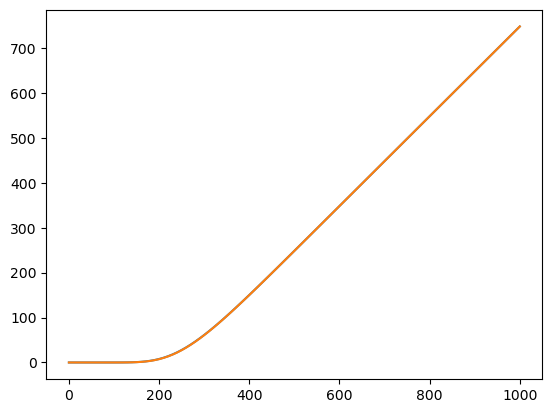

In [26]:
plt.plot(S, C2[0, :])
plt.plot(S, C0exact)

In [27]:
max(abs(C2[0, :] - C0exact))

0.4123596992101284

In [28]:
C2

array([[0.00000000e+00, 3.74032796e-13, 6.01167135e-11, ...,
        7.28263069e+02, 7.38263031e+02, 7.48262993e+02],
       [0.00000000e+00, 3.67605915e-13, 5.91614031e-11, ...,
        7.28245447e+02, 7.38245409e+02, 7.48245370e+02],
       [0.00000000e+00, 3.61281195e-13, 5.82200125e-11, ...,
        7.28227823e+02, 7.38227785e+02, 7.48227747e+02],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.10047797e+02, 7.20047797e+02, 7.30047796e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.10028899e+02, 7.20028899e+02, 7.30028899e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.10010000e+02, 7.20010000e+02, 7.30010000e+02]])

In [57]:
# equiv avec produit de matrice
A2 = np.diag(1 - dt * (sigma ** 2 / ds ** 2) * S[1:N] ** 2 - dt * r * S[1:N] / ds - dt * r) \
     + np.diag(dt * 0.5 * (sigma / ds) ** 2 * S[1:N - 1] ** 2 + dt * r / ds * S[1:N - 1], 1) \
     + np.diag(dt * 0.5 * (sigma / ds) ** 2 * S[2:N] ** 2, -1)

np.linalg.eig(A2)[0]




array([0.99999104, 0.99998705, 0.99998024, 0.9999702 , 0.99995656,
       0.99993893, 0.99991694, 0.99989022, 0.99985843, 0.99967322,
       0.99972895, 0.99982119, 0.99977815, 0.99961059, 0.9995407 ,
       0.99946316, 0.9993776 , 0.99928361, 0.99918081, 0.99906879,
       0.99894714, 0.99881544, 0.99867325, 0.9981793 , 0.99835563,
       0.99852013, 0.99799065, 0.9977892 , 0.99757445, 0.99734589,
       0.99710298, 0.9968452 , 0.99657197, 0.99628273, 0.99597687,
       0.99531288, 0.9956538 , 0.99495345, 0.99457486, 0.99417639,
       0.99375734, 0.99331696, 0.99285447, 0.99236909, 0.99185998,
       0.99132627, 0.98892716, 0.98825637, 0.99076709, 0.98956852,
       0.98755505, 0.98682206, 0.98605621, 0.98525625, 0.98442087,
       0.9835487 , 0.99018149, 0.9826383 , 0.98168816, 0.98069669,
       0.97244563, 0.97505728, 0.97377911, 0.97628252, 0.9796622 ,
       0.97745704, 0.97105433, 0.96960252, 0.96808733, 0.87642199,
       0.96650566, 0.9594439 , 0.95747448, 0.96132735, 0.95541

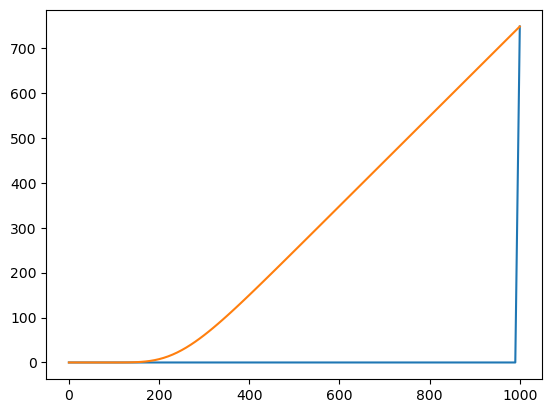

In [51]:
plt.plot(S, C2[0, :])
plt.plot(S, C0exact)